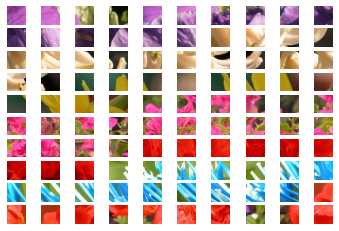

(11070, 41, 41, 3)


In [116]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import random

imgs = []
sub_image_size = 41
channel_num = 3

#Load train data
dir = "./train_data/291/"#Your path
for i in range(1, 201):
    img_path = dir + "img (" + str(i) + ")"
    try:
        img = plt.imread(img_path + ".bmp")
        
    except:
        img = plt.imread(img_path + ".jpg")
    #Cropping image
    img = tf.image.extract_patches(np.array([img]), [1, sub_image_size, sub_image_size, 1], [
                             1, sub_image_size, sub_image_size, 1], [1, 1, 1, 1], 'VALID')
    
    img = tf.reshape(img, [-1, sub_image_size, sub_image_size, 3])
    imgs.append(img)
imgs = np.vstack(imgs)

for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i*10+j+1)
        plt.axis('off')
        plt.imshow(imgs[i*10+j].astype('uint8'))
plt.show()

print(imgs.shape)


In [117]:
#Now, split data into train/validation
#Ratio is 8:2
size_train = int(imgs.shape[0]*0.8)
size_val = imgs.shape[0]-size_train

np.random.shuffle(imgs)

Y_train = imgs[:size_train]
Y_val = imgs[size_train:size_train+size_val]

print("Train data shape :", Y_train.shape)
print("Validation data shape :", Y_val.shape)



Train data shape : (8856, 41, 41, 3)
Validation data shape : (2214, 41, 41, 3)


In [118]:
from tensorflow.keras import layers
import random
#Create custom model
class Model(tf.keras.Model):
    def __init__(self, **kwargs):
        super(Model, self).__init__(**kwargs)
        self.augmentation = tf.keras.Sequential([
          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
          layers.experimental.preprocessing.RandomRotation(0.2),
        ])
        self.cnn_in = tf.keras.layers.Conv2D(input_shape=(None, None, channel_num), kernel_size=3, 
                                        filters=64, padding='same', activation='relu', kernel_initializer='he_normal',
                                            kernel_regularizer = tf.keras.regularizers.l2(0.0001))
        self.cnns = tf.keras.Sequential()
        for i in range(18):
            self.cnns.add(tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same',activation='relu', 
                                      kernel_initializer='he_normal', kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
        self.cnn_out = tf.keras.layers.Conv2D(kernel_size=3, filters=channel_num, padding='same', activation='tanh',
                                             kernel_regularizer = tf.keras.regularizers.l2(0.0001))
    def call(self, imgs, r=[2,3,4], downSample=False, training=False):
        #r is list of scaling factor which will be randomly selected.
        #If downSample is True, input will be downsampled by r, and then upsampled to original size using bicubic
        #so that you can compare with ground truth.
        #If downSample is False, you can use it for real world application
        #where ground truth doesn't exist.
        #If training is True, data augmentation will be applied.
        if training==True:
            #Data augmentation
            l = [imgs]
            for i in range(3):
                l.append(self.augmentation(imgs))
            imgs = tf.stack(l, axis=0)
            imgs = tf.reshape(imgs, [-1,imgs.shape[2], imgs.shape[3], channel_num])
            
        
        #Normalization
        imgs = tf.cast(imgs, dtype=tf.float32)
        
        imgs = imgs - 127.5
        imgs = imgs/255
        
        r_rand = random.choice(r)
        H = imgs.shape[1]
        W = imgs.shape[2]
            
        if downSample==False:
            X = tf.image.resize(imgs, [H*r_rand,W*r_rand], method='bicubic')
        if downSample==True:
            #Make ILR images
            r_rand = random.choice(r)
            H = imgs.shape[1]
            W = imgs.shape[2]
            H_reduced = int(H/r_rand)
            W_reduced = int(W/r_rand)
            
    #NOTE!!!
    #There seems to be issues about tf.image.resize.
    #Results of bicubic is different with other frameworks.
    #Therefore PSNR of bicubic was very lower than paper's.
    #https://twitter.com/poolio/status/1280689329908543488?s=20&fbclid=IwAR2TT2wXZwruvg9Q4ohlcm5bSlZexFnov1T9IBenIopBEhv2Q6r8mP7ubp4
    #Above link addressing this problem.
    #Adding antialias=True to tf.image.resize results almost same with PIL's bicubic.
            X = tf.image.resize(imgs, [H_reduced,W_reduced], method='bicubic',antialias=True)
            
            X = tf.image.resize(X, [H,W], method='bicubic')
            
            
        #Residual learning
        residual = self.cnn_in(X)
        
        residual = self.cnns(residual)
        residual = self.cnn_out(residual)
        
        output = tf.keras.layers.Add()((residual, X))#Skip connection
        if downSample==False:
            return output
        loss = tf.reduce_mean(tf.square(imgs-output))
        bicubic_loss = tf.reduce_mean(tf.square(imgs-X))
        return output, loss, bicubic_loss
        
model = Model()
model(Y_train[0:1], training=True) #To see summary of custom model, it should be runned first.
model.summary()





Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   multiple                  0         
_________________________________________________________________
conv2d_100 (Conv2D)          multiple                  1792      
_________________________________________________________________
sequential_11 (Sequential)   multiple                  664704    
_________________________________________________________________
conv2d_119 (Conv2D)          multiple                  1731      
Total params: 668,227
Trainable params: 668,227
Non-trainable params: 0
_________________________________________________________________


In [231]:
epoch_num=50
batch_size = 16
Y_train_tensor = tf.data.Dataset.from_tensor_slices(Y_train).batch(batch_size)
Y_val_tensor = tf.data.Dataset.from_tensor_slices(Y_val).batch(batch_size)
batchNum_train = Y_train.shape[0]//batch_size + 1
batchNum_val = Y_val.shape[0]//batch_size + 1
#Decay learning_rate to half every 10 epochs.
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.001,
                                                               batchNum_train*10, 0.5, staircase=True
                                                              )

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_train_list = []
loss_val_list = []
loss_bicubic_train_list = []
loss_bicubic_val_list = []
last_epoch = 0
best_diff = -0.0008

In [232]:
#Train with custom loop
#You can stop and restart the loop

for epoch in range(last_epoch+1, last_epoch+1+epoch_num):
    last_epoch = epoch
    loss_train = 0
    bicubic_loss_train = 0
    for Y in Y_train_tensor:
        with tf.GradientTape() as tape:
            _, loss_train_batch, bicubic_loss = model.call(Y, downSample=True, training=True)
        
        
        loss_train += loss_train_batch.numpy()/batchNum_train
        bicubic_loss_train += bicubic_loss.numpy()/batchNum_train
        grad = tape.gradient(loss_train_batch, model.trainable_variables)
        
        optimizer.apply_gradients(grads_and_vars=zip(grad, model.trainable_variables))
    
    loss_val = 0
    bicubic_loss_val = 0
    for Y_valid in Y_val_tensor:
        _, loss_val_batch, bicubic_loss_ = model.call(Y_valid, downSample=True)
        loss_val += loss_val_batch.numpy()/batchNum_val
        bicubic_loss_val += bicubic_loss_.numpy()/batchNum_val
    
    print("Epoch :",epoch,"----Train----","Bicubic_loss :", bicubic_loss_train, "train loss :", loss_train, "diff :", loss_train-bicubic_loss_train)
    print("----Validation---- Bicubic_loss", bicubic_loss_val, "validation loss :", loss_val, "diff :", loss_val-bicubic_loss_val)
    loss_train_list.append(loss_train)
    loss_val_list.append(loss_val)
    
    loss_bicubic_train_list.append(bicubic_loss_train)
    loss_bicubic_val_list.append(bicubic_loss_val)
    
    """
    #Save best checkpoint
    diff = loss_val-bicubic_loss_val
    if diff<best_diff:
        root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)
        checkpoint_dir = './ckpt_'+ str(diff*1000)[:3] + "_" + str(epoch)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        root.save(checkpoint_prefix)
        print("---------------------saved--------------------")
    
"""

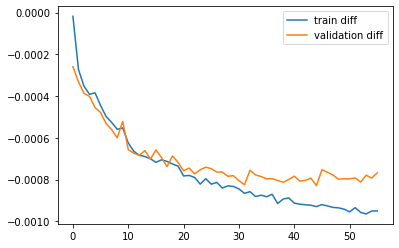

In [132]:
plt.plot(np.array(loss_train_list)-np.array(loss_bicubic_train_list), label='train diff')
plt.plot(np.array(loss_val_list)-np.array(loss_bicubic_val_list), label='validation diff')
plt.legend()

plt.show()


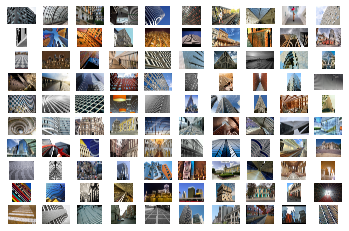

In [214]:
#Test data loaded
test_imgs = []
max_num = 100
dir = "./test_data/Urban100/"#Your path
for i in range(1, max_num+1):
    img_path = dir + "img (" + str(i) + ")"
    try:
        img = plt.imread(img_path + ".bmp")
        
    except:
        img = plt.imread(img_path + ".jpg")
    test_imgs.append(img)

for i in range(int(np.sqrt(max_num))):
    for j in range(int(np.sqrt(max_num))):
        plt.subplot(int(np.sqrt(max_num)), int(np.sqrt(max_num)), i*int(np.sqrt(max_num))+j+1)
        plt.axis('off')
        plt.imshow(test_imgs[i*int(np.sqrt(max_num))+j].astype('uint8'))
plt.show()

In [222]:
def test():
    r = 4
    psnr_bicubic_mean = 0
    psnr_fake_mean = 0
   
    for image in test_imgs:
        output,_,__ = model.call([image], r=[r], downSample=True)
        output = (output*255+127.5).numpy()[0]
        output = np.clip(output,0,255).astype('uint8')
        
        
        image_bicubic = tf.image.resize(image, [image.shape[0]//r, image.shape[1]//r], method='bicubic',antialias=True)
        
        image_bicubic = tf.image.resize(image_bicubic, [image.shape[0], image.shape[1]], method='bicubic').numpy()
        image_bicubic = np.clip(image_bicubic, 0, 255).astype('uint8')
    
        psnr_bicubic = tf.image.psnr(image, image_bicubic, max_val=255)
        psnr_fake = tf.image.psnr(image, output, max_val=255)
    
        psnr_bicubic_mean += psnr_bicubic.numpy()/len(test_imgs)
        psnr_fake_mean += psnr_fake.numpy()/len(test_imgs)
       
    print("Scale :",r,"Bicubic psnr :", psnr_bicubic_mean, "VDSR psnr : ", psnr_fake_mean)
    
#Restore best model
#root.restore(tf.train.latest_checkpoint('./ckpt_811_299'))

test()

Scale : 4 Bicubic psnr : 21.691510190963747 VDSR psnr :  23.037764682769776
[24, 39, 42, 54, 80]


bicubic :  24.64355 fake :  26.27865


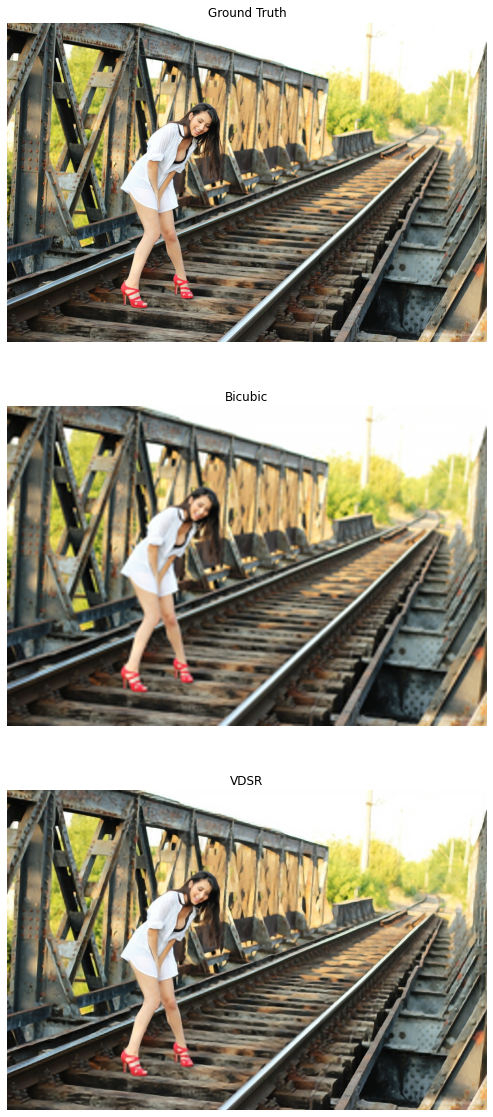

In [230]:
#See result
test_index = 6#Index of test_imgs
image = test_imgs[test_index]
r = 4
output,_,__ = model.call([image], r=[r], downSample=True)
output = (output*255+127.5).numpy()[0]
output = np.clip(output,0,255).astype('uint8')
#output[output<0] = 0
image_bicubic = tf.image.resize(image, [image.shape[0]//r, image.shape[1]//r], method='bicubic',antialias=True)
image_bicubic = tf.image.resize(image_bicubic, [image.shape[0], image.shape[1]], method='bicubic').numpy()

"""
###Bicubic with PIL###

image_bicubic = PIL.Image.fromarray(image)
image_bicubic = image_bicubic.resize((image_bicubic.width//r, image_bicubic.height//r), PIL.Image.BICUBIC)
image_bicubic = image_bicubic.resize((image.shape[1], image.shape[0]), PIL.Image.BICUBIC)
image_bicubic = np.array(image_bicubic)
"""
image_bicubic = np.clip(image_bicubic, 0, 255).astype('uint8')
plt.figure(figsize=(20,20))

plt.subplot(3, 1, 1)
plt.axis('off')
plt.title("Ground Truth")
plt.imshow(image.astype('uint8'))

plt.subplot(3, 1, 2)
plt.axis('off')
plt.title("Bicubic")
plt.imshow(image_bicubic.astype('uint8'))

plt.subplot(3, 1, 3)
plt.axis('off')
plt.title("VDSR")
plt.imshow(output.astype('uint8'))

psnr_bicubic = tf.image.psnr(image, image_bicubic, max_val=255)
psnr_fake = tf.image.psnr(image, output, max_val=255)

print("bicubic : ", psnr_bicubic.numpy(), "fake : ", psnr_fake.numpy())




In [226]:
def save_with_bicubic(image, path, r=4):
    output, _, __ = model.call([image], r=[r], downSample=True)
    output = (output*255+127.5).numpy()[0]
    output = np.clip(output, 0, 255).astype('uint8')

    image_bicubic = tf.image.resize(
    image, [image.shape[0]//r, image.shape[1]//r], method='bicubic',antialias=True)
    image_bicubic = tf.image.resize(
    image_bicubic, [image.shape[0], image.shape[1]], method='bicubic').numpy()
    image_bicubic = np.clip(image_bicubic, 0, 255).astype('uint8')
    tf.keras.preprocessing.image.save_img(
        path+"/gt.png", image, data_format="channels_last", file_format=None, scale=False
    )
    tf.keras.preprocessing.image.save_img(
        path+"/fake.png", output, data_format="channels_last", file_format=None, scale=False
    )
    tf.keras.preprocessing.image.save_img(
        path+"/bicubic.png", image_bicubic, data_format="channels_last", file_format=None, scale=False
    )
save_with_bicubic(test_imgs[42], "./results", r=4)